## Convolutional autoencoder 

In [1]:

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import segyio
from tqdm import tqdm
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:

# Dataset Class
class SeismicDataset(Dataset):
    def __init__(self, seismic, fault, augmentations=None):
        self.seismic = seismic
        self.fault = fault
        self.augmentations = augmentations

    def __len__(self):
        return len(self.seismic)

    def __getitem__(self, idx):
        seismic_slice = torch.tensor(self.seismic[idx], dtype=torch.float32).unsqueeze(0)
        fault_slice = torch.tensor(self.fault[idx], dtype=torch.float32).unsqueeze(0)

        if self.augmentations:
            seismic_slice = self.augmentations(seismic_slice)
        
        return seismic_slice, fault_slice

In [3]:
# Enhanced Autoencoder Architecture
class EnhancedAutoencoder(nn.Module):
    def __init__(self):
        super(EnhancedAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),  # 64x256x256
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 128x128x128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # 256x64x64
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128x128x128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x256x256
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 1x512x512
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
# Dataset Class
class SeismicDataset(Dataset):
    def __init__(self, seismic, fault, augmentations=None):
        self.seismic = seismic
        self.fault = fault
        self.augmentations = augmentations

    def __len__(self):
        return len(self.seismic)

    def __getitem__(self, idx):
        seismic_slice = torch.tensor(self.seismic[idx], dtype=torch.float32).unsqueeze(0)
        fault_slice = torch.tensor(self.fault[idx], dtype=torch.float32).unsqueeze(0)

        if self.augmentations:
            seismic_slice = self.augmentations(seismic_slice)
        
        return seismic_slice, fault_slice


In [5]:
# Loss Function
class DiceLoss(nn.Module):
    def forward(self, inputs, targets, smooth=1):
        # Use .reshape(-1) instead of .view(-1)
        inputs = inputs.reshape(-1)
        targets = targets.reshape(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice


class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        dice_loss = self.dice(inputs, targets)
        return 0.8*bce_loss + 0.2*dice_loss


In [6]:
#  Training Function
def train_model(model, dataloader, val_dataloader, n_epochs, optimizer, scheduler, criterion, device):
    model = model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0

        with tqdm(dataloader, desc=f"Epoch {epoch+1}/{n_epochs}", unit="batch") as progress_bar:
            for seismic_batch, fault_batch in progress_bar:
                seismic_batch, fault_batch = seismic_batch.to(device), fault_batch.to(device)

                # Forward pass
                optimizer.zero_grad()
                outputs = model(seismic_batch)

                # Crop outputs to match fault_batch
                crop_h = outputs.shape[2] - fault_batch.shape[2]
                crop_w = outputs.shape[3] - fault_batch.shape[3]
                outputs = outputs[:, :, :outputs.shape[2] - crop_h, :outputs.shape[3] - crop_w]

                # Compute loss
                loss = criterion(outputs, fault_batch)

                # Backward pass
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                progress_bar.set_postfix(loss=loss.item())

        scheduler.step(epoch_loss)
        train_losses.append(epoch_loss / len(dataloader))
        print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_losses[-1]:.4f}")

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for seismic_batch, fault_batch in val_dataloader:
                seismic_batch, fault_batch = seismic_batch.to(device), fault_batch.to(device)
                outputs = model(seismic_batch)

                # Crop outputs to match fault_batch
                crop_h = outputs.shape[2] - fault_batch.shape[2]
                crop_w = outputs.shape[3] - fault_batch.shape[3]
                outputs = outputs[:, :, :outputs.shape[2] - crop_h, :outputs.shape[3] - crop_w]

                val_loss += criterion(outputs, fault_batch).item()

        val_losses.append(val_loss / len(val_dataloader))
        print(f"Epoch {epoch+1}/{n_epochs}, Validation Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses



In [7]:
# Visualization Function
def visualize_results(model, dataloader, device, num_samples=2):
    model.eval()
    with torch.no_grad():
        seismic_batch, fault_batch = next(iter(dataloader))
        seismic_batch = seismic_batch.to(device)
        reconstructed = model(seismic_batch).cpu().numpy()

        for i in range(min(num_samples, len(seismic_batch))):
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 3, 1)
            plt.title("Seismic Input")
            plt.imshow(seismic_batch[i].cpu().squeeze(), cmap="seismic")

            plt.subplot(1, 3, 2)
            plt.title("Ground Truth Fault")
            plt.imshow(fault_batch[i].squeeze(), cmap="gray")

            plt.subplot(1, 3, 3)
            plt.title("Predicted Fault")
            plt.imshow(reconstructed[i].squeeze(), cmap="gray")

            plt.show()


In [8]:
filename_seismic = "C:\\Users\\hsk21\\Desktop\\MLcourse\\github\\Seismic-Fault-Detection-using-Convolutional-Neural-Network\\Equinor Synthetic model\\Equinor Synthetic model\\issap20_Pp.sgy"
filename_ai = "C:\\Users\\hsk21\\Desktop\\MLcourse\\github\\Seismic-Fault-Detection-using-Convolutional-Neural-Network\\Equinor Synthetic model\\Equinor Synthetic model\\issap20_Fault.sgy"
filename_fault = "C:\\Users\\hsk21\\Desktop\\MLcourse\\github\\Seismic-Fault-Detection-using-Convolutional-Neural-Network\\Equinor Synthetic model\\Equinor Synthetic model\\issap20_Fault.sgy"



In [9]:
# Note: the the xline header info location is at segyio.su.cdpx [181]
def segy2numpy(filename: str) -> np.array:
    with segyio.open(filename, xline=181) as segyfile:
        return segyio.tools.cube(segyfile)


In [10]:
# Load data
seismic = segy2numpy(filename_seismic)
fault = segy2numpy(filename_fault)

# Normalize data
seismic = (seismic - np.min(seismic)) / (np.max(seismic) - np.min(seismic))


In [11]:
# Split data into training and validation sets
seismic_train, seismic_val, fault_train, fault_val = train_test_split(
    seismic, fault, test_size=0.2, random_state=42
)

# Augmentations
# augmentations = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(degrees=15),
# ])

In [12]:
# Create datasets and dataloaders
train_dataset = SeismicDataset(seismic_train, fault_train, augmentations=None)
val_dataset = SeismicDataset(seismic_val, fault_val)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Initialize model, loss, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedAutoencoder().to(device)
criterion = BCEDiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)


c:\Users\hsk21\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [13]:
# Train the model
train_losses, val_losses = train_model(
    model, train_dataloader, val_dataloader, n_epochs=20,
    optimizer=optimizer, scheduler=scheduler, criterion=criterion, device=device)

Epoch 1/20: 100%|██████████| 20/20 [00:38<00:00,  1.93s/batch, loss=0.62] 


Epoch 1/20, Training Loss: 0.7214
Epoch 1/20, Validation Loss: 0.7315


Epoch 2/20: 100%|██████████| 20/20 [00:37<00:00,  1.89s/batch, loss=0.519]


Epoch 2/20, Training Loss: 0.5609
Epoch 2/20, Validation Loss: 0.5201


Epoch 3/20: 100%|██████████| 20/20 [00:37<00:00,  1.88s/batch, loss=0.463]


Epoch 3/20, Training Loss: 0.4868
Epoch 3/20, Validation Loss: 0.4553


Epoch 4/20: 100%|██████████| 20/20 [00:38<00:00,  1.93s/batch, loss=0.426]


Epoch 4/20, Training Loss: 0.4422
Epoch 4/20, Validation Loss: 0.4206


Epoch 5/20: 100%|██████████| 20/20 [00:38<00:00,  1.93s/batch, loss=0.4]  


Epoch 5/20, Training Loss: 0.4118
Epoch 5/20, Validation Loss: 0.3964


Epoch 6/20: 100%|██████████| 20/20 [00:39<00:00,  1.96s/batch, loss=0.382]


Epoch 6/20, Training Loss: 0.3902
Epoch 6/20, Validation Loss: 0.3782


Epoch 7/20: 100%|██████████| 20/20 [00:39<00:00,  1.99s/batch, loss=0.367]


Epoch 7/20, Training Loss: 0.3742
Epoch 7/20, Validation Loss: 0.3638


Epoch 8/20: 100%|██████████| 20/20 [00:38<00:00,  1.94s/batch, loss=0.353]


Epoch 8/20, Training Loss: 0.3615
Epoch 8/20, Validation Loss: 0.3525


Epoch 9/20: 100%|██████████| 20/20 [00:38<00:00,  1.94s/batch, loss=0.346]


Epoch 9/20, Training Loss: 0.3510
Epoch 9/20, Validation Loss: 0.3424


Epoch 10/20: 100%|██████████| 20/20 [00:38<00:00,  1.93s/batch, loss=0.339]


Epoch 10/20, Training Loss: 0.3419
Epoch 10/20, Validation Loss: 0.3326


Epoch 11/20: 100%|██████████| 20/20 [00:38<00:00,  1.94s/batch, loss=0.33] 


Epoch 11/20, Training Loss: 0.3334
Epoch 11/20, Validation Loss: 0.3227


Epoch 12/20: 100%|██████████| 20/20 [00:37<00:00,  1.89s/batch, loss=0.321]


Epoch 12/20, Training Loss: 0.3252
Epoch 12/20, Validation Loss: 0.3181


Epoch 13/20: 100%|██████████| 20/20 [00:38<00:00,  1.91s/batch, loss=0.314]


Epoch 13/20, Training Loss: 0.3172
Epoch 13/20, Validation Loss: 0.3103


Epoch 14/20: 100%|██████████| 20/20 [00:38<00:00,  1.92s/batch, loss=0.305]


Epoch 14/20, Training Loss: 0.3094
Epoch 14/20, Validation Loss: 0.2995


Epoch 15/20: 100%|██████████| 20/20 [00:40<00:00,  2.01s/batch, loss=0.298]


Epoch 15/20, Training Loss: 0.3019
Epoch 15/20, Validation Loss: 0.2892


Epoch 16/20: 100%|██████████| 20/20 [00:38<00:00,  1.91s/batch, loss=0.292]


Epoch 16/20, Training Loss: 0.2948
Epoch 16/20, Validation Loss: 0.2847


Epoch 17/20: 100%|██████████| 20/20 [00:38<00:00,  1.91s/batch, loss=0.286]


Epoch 17/20, Training Loss: 0.2882
Epoch 17/20, Validation Loss: 0.2716


Epoch 18/20: 100%|██████████| 20/20 [00:37<00:00,  1.87s/batch, loss=0.28] 


Epoch 18/20, Training Loss: 0.2820
Epoch 18/20, Validation Loss: 0.2706


Epoch 19/20: 100%|██████████| 20/20 [00:37<00:00,  1.85s/batch, loss=0.274]


Epoch 19/20, Training Loss: 0.2761
Epoch 19/20, Validation Loss: 0.2689


Epoch 20/20: 100%|██████████| 20/20 [00:38<00:00,  1.90s/batch, loss=0.267]


Epoch 20/20, Training Loss: 0.2705
Epoch 20/20, Validation Loss: 0.2586


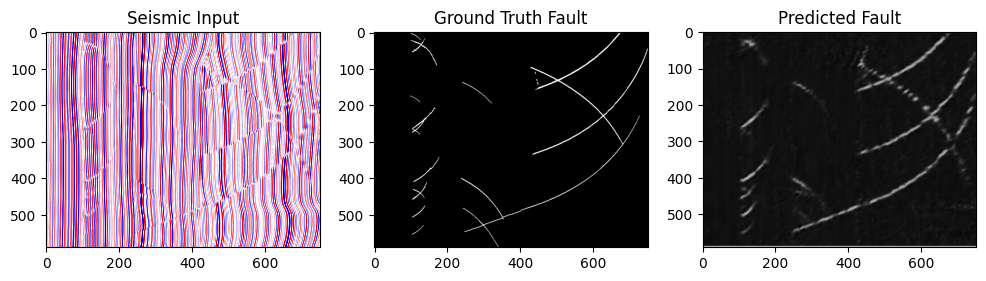

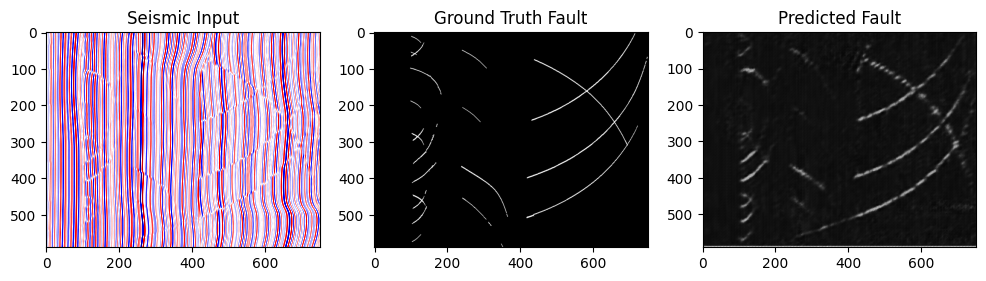

In [14]:
# Visualize results
visualize_results(model, train_dataloader, device)